In [1]:
# !/usr/bin/python3
# -*- encoding: utf-8 -*-

import matplotlib.pyplot as plt
import numpy as np
import tushare as ts
import pandas as pd
import torch
from torch import nn
import datetime
import time

DAYS_FOR_TRAIN = 10


class LSTM_Regression(nn.Module):
    """
        使用LSTM进行回归
        参数：
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """

    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super().__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, _x):
        x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
        s, b, h = x.shape
        x = x.view(s * b, h)
        x = self.fc(x)
        x = x.view(s, b, -1)  # 把形状改回来
        return x




In [2]:
def create_dataset(data, days_for_train=5) -> (np.array, np.array):
    """
        根据给定的序列data，生成数据集
        数据集分为输入和输出，每一个输入的长度为days_for_train，每一个输出的长度为1。
        也就是说用days_for_train天的数据，对应下一天的数据。
        若给定序列的长度为d，将输出长度为(d-days_for_train+1)个输入/输出对
    """
    dataset_x, dataset_y = [], []
    for i in range(len(data) - days_for_train):
        _x = data[i:(i + days_for_train)]
        dataset_x.append(_x)
        dataset_y.append(data[i + days_for_train])
    return (np.array(dataset_x), np.array(dataset_y))




In [9]:
t0 = time.time()
# 取上证指数的收盘价
data_close = ts.get_k_data('000001', start='2019-01-01', index=True)['close'] 
 # 取上证指数的收盘价
data_close.to_csv('000001.csv', index=False)  # 将下载的数据转存为.csv格式保存
data_close = pd.read_csv('000001.csv')  # 读取文件

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2
(1538, 7)


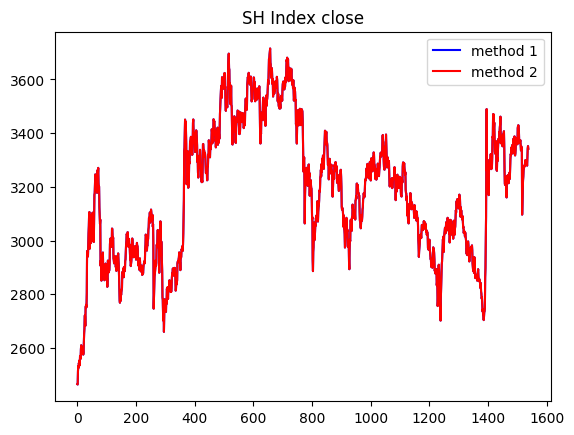

In [10]:
# 获取上海证券交易所（SH）的 K 线数据（更全）
df_sh = ts.get_k_data('sh', start='2019-01-01', end=datetime.datetime.now().strftime('%Y-%m-%d'))
print(df_sh.shape)

data_close = data_close.astype('float32').values  # 转换数据类型

plt.figure()
plt.title("SH Index close")
plt.plot(data_close, 'b', label='method 1')
plt.plot(df_sh.iloc[:, 2], 'r', label='method 2')
plt.savefig('data.png', format='png', dpi=200)
plt.legend()  # 显示图例
plt.show()
plt.close()
# plt.clf()


In [11]:

# 将价格标准化到0~1
max_value = np.max(data_close)
min_value = np.min(data_close)
data_close = (data_close - min_value) / (max_value - min_value)



In [13]:
# dataset_x
# 是形状为(样本数, 时间窗口大小)
# 的二维数组，用于训练模型的输入
# dataset_y
# 是形状为(样本数, )
# 的一维数组，用于训练模型的输出。
dataset_x, dataset_y = create_dataset(data_close, DAYS_FOR_TRAIN)  # 分别是（1007,10,1）（1007,1）

# 划分训练集和测试集，70%作为训练集
train_size = int(len(dataset_x) * 0.5)

train_x = dataset_x[:train_size]
train_y = dataset_y[:train_size]


In [14]:
# 将数据改变形状，RNN 读入的数据维度是 (seq_size, batch_size, feature_size)
train_x = train_x.reshape(-1, 1, DAYS_FOR_TRAIN)
train_y = train_y.reshape(-1, 1, 1)



In [15]:
# 转为pytorch的tensor对象
train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)

Number of model_total parameter: 0.00122500M
Epoch: 1, Loss:0.65656
Epoch: 2, Loss:0.56073
Epoch: 3, Loss:0.47296
Epoch: 4, Loss:0.39177
Epoch: 5, Loss:0.31637
Epoch: 6, Loss:0.24662
Epoch: 7, Loss:0.18357
Epoch: 8, Loss:0.12923
Epoch: 9, Loss:0.08610
Epoch: 10, Loss:0.05709
Epoch: 11, Loss:0.04484
Epoch: 12, Loss:0.04999
Epoch: 13, Loss:0.06698
Epoch: 14, Loss:0.08313
Epoch: 15, Loss:0.09013
Epoch: 16, Loss:0.08793
Epoch: 17, Loss:0.08001
Epoch: 18, Loss:0.07011
Epoch: 19, Loss:0.06098
Epoch: 20, Loss:0.05408
Epoch: 21, Loss:0.04981
Epoch: 22, Loss:0.04788
Epoch: 23, Loss:0.04769
Epoch: 24, Loss:0.04852
Epoch: 25, Loss:0.04978
Epoch: 26, Loss:0.05099
Epoch: 27, Loss:0.05181
Epoch: 28, Loss:0.05208
Epoch: 29, Loss:0.05171
Epoch: 30, Loss:0.05072
Epoch: 31, Loss:0.04919
Epoch: 32, Loss:0.04723
Epoch: 33, Loss:0.04496
Epoch: 34, Loss:0.04252
Epoch: 35, Loss:0.03999
Epoch: 36, Loss:0.03747
Epoch: 37, Loss:0.03498
Epoch: 38, Loss:0.03250
Epoch: 39, Loss:0.02999
Epoch: 40, Loss:0.02734
Epoc

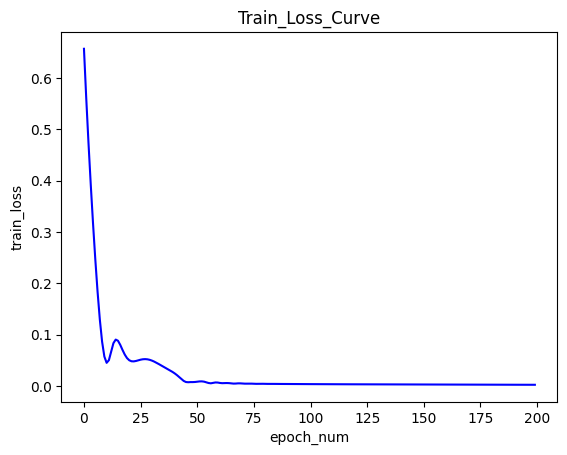

The training time took 66.78 mins.
The starting time was  Sun May 11 01:52:42 2025
The finishing time was  Sun May 11 02:59:28 2025


In [16]:
model = LSTM_Regression(DAYS_FOR_TRAIN, 8, output_size=1, num_layers=2)  # 导入模型并设置模型的参数输入输出层、隐藏层等

model_total = sum([param.nelement() for param in model.parameters()])  # 计算模型参数
print("Number of model_total parameter: %.8fM" % (model_total / 1e6))

train_loss = []
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
for i in range(200):
    out = model(train_x)
    loss = loss_function(out, train_y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    train_loss.append(loss.item())

    # 将训练过程的损失值写入文档保存，并在终端打印出来
    with open('log.txt', 'a+') as f:
        f.write('{} - {}\n'.format(i + 1, loss.item()))
    if (i + 1) % 1 == 0:
        print('Epoch: {}, Loss:{:.5f}'.format(i + 1, loss.item()))

# 画loss曲线
plt.figure()
plt.plot(train_loss, 'b', label='loss')
plt.title("Train_Loss_Curve")
plt.ylabel('train_loss')
plt.xlabel('epoch_num')
plt.savefig('loss.png', format='png', dpi=200)
plt.show()
plt.close()

torch.save(model.state_dict(), 'model_params.pkl')  # 可以保存模型的参数供未来使用
torch.save(model.state_dict(), 'model_params.pth')  # 可以保存模型的参数供未来使用
t1 = time.time()
T = t1 - t0
print('The training time took %.2f' % (T / 60) + ' mins.')

tt0 = time.asctime(time.localtime(t0))
tt1 = time.asctime(time.localtime(t1))
print('The starting time was ', tt0)
print('The finishing time was ', tt1)

# for test
model = model.eval()  # 转换成评估模式
# model.load_state_dict(torch.load('model_params.pkl'))  # 读取参数

# 注意这里用的是全集 模型的输出长度会比原数据少DAYS_FOR_TRAIN 填充使长度相等再作图
dataset_x = dataset_x.reshape(-1, 1, DAYS_FOR_TRAIN)  # (seq_size, batch_size, feature_size)
dataset_x = torch.from_numpy(dataset_x)

pred_test = model(dataset_x)  # 全量训练集
# 的模型输出 (seq_size, batch_size, output_size)
pred_test = pred_test.view(-1).data.numpy()
pred_test = np.concatenate((np.zeros(DAYS_FOR_TRAIN), pred_test))  # 填充0 使长度相同
assert len(pred_test) == len(data_close)

plt.plot(pred_test, 'r', label='prediction')
plt.plot(data_close, 'b', label='real')
plt.plot((train_size, train_size), (0, 1), 'g--')  # 分割线 左边是训练数据 右边是测试数据的输出
plt.legend(loc='best')
plt.savefig('result.png', format='png', dpi=200)
plt.show()
plt.close()

In [18]:
import onnx
import onnx.utils
import onnx.version_converter


# 定义数据+网络
data = torch.randn(2, 1, 10)
# net = model.resnet34()
net = model
# 导出
torch.onnx.export(
    net,
    data,
    'model.onnx',
    export_params=True,
    opset_version=8,
)

# 增加维度信息
model_file = 'model.onnx'
onnx_model = onnx.load(model_file)
onnx.save(onnx.shape_inference.infer_shapes(onnx_model), model_file)

d:\miniconda3\envs\deepLearning\lib\site-packages\torch\onnx\symbolic_opset9.py:4662: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(
d:\miniconda3\envs\deepLearning\lib\site-packages\torch\onnx\utils.py:702: UserWarning: Constant folding - unsupported opset version. Constant folding not applied. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\jit\passes\onnx\constant_fold.cpp:347.)
  _C._jit_pass_onnx_graph_shape_type_inference(
d:\miniconda3\envs\deepLearning\lib\site-packages\torch\onnx\utils.py:702: UserWarning: Constant folding - unsupported opset version. Constant folding not applied. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorc